In [8]:
# -*- coding: utf-8 -*-
# Create time: 2025-09-25
# Update time: 2025-11-15

# conda activate benchmark
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import List
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
mpl.rcParams['font.family'] = 'Arial'


class EmbeddingMetrics:
    def __init__(self, df: pd.DataFrame):
        """
        直接用 DataFrame 构造：
        第一行为某 embedding 的指标值，最后一行为 metric 类型
        """
        self.metric_values = df.iloc[0:1].copy()
        self.metric_types = df.iloc[1:2].copy()
        self.embedding_name = self.metric_values.index[0]

    @classmethod
    def from_file(cls, filepath: str):
        df = pd.read_csv(filepath, index_col=0)
        return cls(df)

    def get_value(self, col_name: str) -> float | None:
        """返回指定指标的数值"""
        if col_name in self.metric_values.columns:
            return float(self.metric_values[col_name].values[0])
        else:
            print(f"[Warning] 指标列 '{col_name}' 不存在。")
            return None

    def rename_embedding(self, new_name: str):
        """修改 embedding 名称"""
        self.metric_values.index = [new_name]
        self.embedding_name = new_name

    def add_column(self, col_name: str, col_type: str, value: float):
        """添加新的一列指标及其类型，按指标类型插入到对应位置"""
        if col_name in self.metric_values.columns:
            print(f"[Warning] 列 '{col_name}' 已存在，跳过添加。")
            return

        # 获取所有当前指标列
        all_cols = list(self.metric_values.columns)

        # 找到相同类型的最后一个列的索引位置
        insert_idx = None
        for i, col in enumerate(all_cols):
            if self.metric_types[col].values[0] == col_type:
                insert_idx = i + 1  # 插入到这个后面

        # 若找不到同类指标，就加到最前或最后
        if insert_idx is None:
            insert_idx = 0  # 默认插在最前（也可以改为 len(all_cols) 插最后）

        # 插入到指定位置
        for df in [self.metric_values, self.metric_types]:
            df.insert(loc=insert_idx, column=col_name, value=value if df is self.metric_values else col_type)

    def delete_column(self, col_name: str):
        """从指标中删除指定列（指标值和类型都一起删）"""
        if col_name in self.metric_values.columns:
            self.metric_values.drop(columns=[col_name], inplace=True)
            self.metric_types.drop(columns=[col_name], inplace=True)
        else:
            print(f"[Warning] 列名 '{col_name}' 不存在，跳过删除。")

    def filter_columns(self, keep_cols: List[str]):
        """
        只保留指定的指标列（指标值和类型都一起筛选）
        """
        current_cols = set(self.metric_values.columns)
        keep_set = set(keep_cols)
        drop_cols = list(current_cols - keep_set)
        self.metric_values.drop(columns=drop_cols, inplace=True)
        self.metric_types.drop(columns=drop_cols, inplace=True)

    def update_value(self, col_name: str, new_value: float):
        """更新已有指标的数值"""
        self.metric_values[col_name] = new_value

    def compute_scores(self, weights: dict = None):
        """
        自动计算三类 Aggregate Score：
        1. Bio conservation: 平均值
        2. Batch correction: 平均值
        3. Total: 加权平均
        """
        if weights is None:
            weights = {
                "Bio conservation": 0.6,
                "Batch correction": 0.4 
            }

        bio_cols = [c for c in self.metric_values.columns if self.metric_types[c].values[0] == "Bio conservation"]
        batch_cols = [c for c in self.metric_values.columns if self.metric_types[c].values[0] == "Batch correction"]

        bio_score = self.metric_values[bio_cols].astype(float).mean(axis=1).values[0] if bio_cols else 0
        batch_score = self.metric_values[batch_cols].astype(float).mean(axis=1).values[0] if batch_cols else 0

        self.metric_values["Bio conservation"] = bio_score
        self.metric_types["Bio conservation"] = "Aggregate score"

        self.metric_values["Batch correction"] = batch_score
        self.metric_types["Batch correction"] = "Aggregate score"

        total_score = bio_score * weights["Bio conservation"] + batch_score * weights["Batch correction"]
        self.metric_values["Total"] = total_score
        self.metric_types["Total"] = "Aggregate score"

    def to_dataframe(self) -> pd.DataFrame:
        return pd.concat([self.metric_values, self.metric_types])

    @staticmethod
    def merge_embeddings(objs: List["EmbeddingMetrics"]) -> pd.DataFrame:
        """
        将多个 EmbeddingMetrics 合并为一个 DataFrame：
        多行指标 + 一行 Metric Type
        """
        rows = [obj.metric_values for obj in objs]
        types = objs[0].metric_types.copy()  # 假设类型一致
        df = pd.concat(rows + [types])
        return df

def plot_results_df(df: pd.DataFrame, show: bool = True, save_dir: str | None = None):
    """
    参数
    ----------
    df : pd.DataFrame
        多行代表不同模型，最后一行为 Metric Type。
    show : bool
        是否显示图像。
    save_dir : str | None
        若提供路径，则保存为 svg 图像。
    """

    # 提取最后一行作为 metric_type 行，并移除
    metric_type_row = df.loc["Metric Type"]
    df = df.drop(index="Metric Type")

    # 转 float
    df = df.astype(np.float64)

    # 指标列分类
    _AGGREGATE_SCORE = "Aggregate score"
    score_cols = [col for col in df.columns if metric_type_row[col] == _AGGREGATE_SCORE]
    other_cols = [col for col in df.columns if metric_type_row[col] != _AGGREGATE_SCORE]

    # 排序主列
    if "Total" in df.columns:
        sort_col = "Total"
    elif "Batch correction" in df.columns:
        sort_col = "Batch correction"
    else:
        sort_col = score_cols[0] if score_cols else other_cols[0]
    df = df.sort_values(by=sort_col, ascending=False)

    # 记录 method 名
    df["Method"] = df.index

    # 画图设置
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=mpl.cm.PRGn, num_stds=2.5)

    column_definitions = [
        ColumnDefinition("Method", width=1.7, textprops={"ha": "left", "weight": "bold"})
    ]

    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1),
            width=1,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(df[col]),
            group=metric_type_row[col],
            formatter="{:.2f}",
        )
        for col in other_cols
    ]

    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": mpl.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            group=metric_type_row[col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(score_cols)
    ]

    with mpl.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.45 * len(df)))
        tab = Table(
            df,
            cell_kw={"linewidth": 0, "edgecolor": "k"},
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=df.columns)

    if show:
        plt.show()

    if save_dir is not None:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "scib_results_batch_normalize.jpg"), format='jpg', dpi=600, bbox_inches='tight')
        # fig.savefig(os.path.join(save_dir, "scib_results.pdf"), format='pdf', bbox_inches='tight')

    return tab


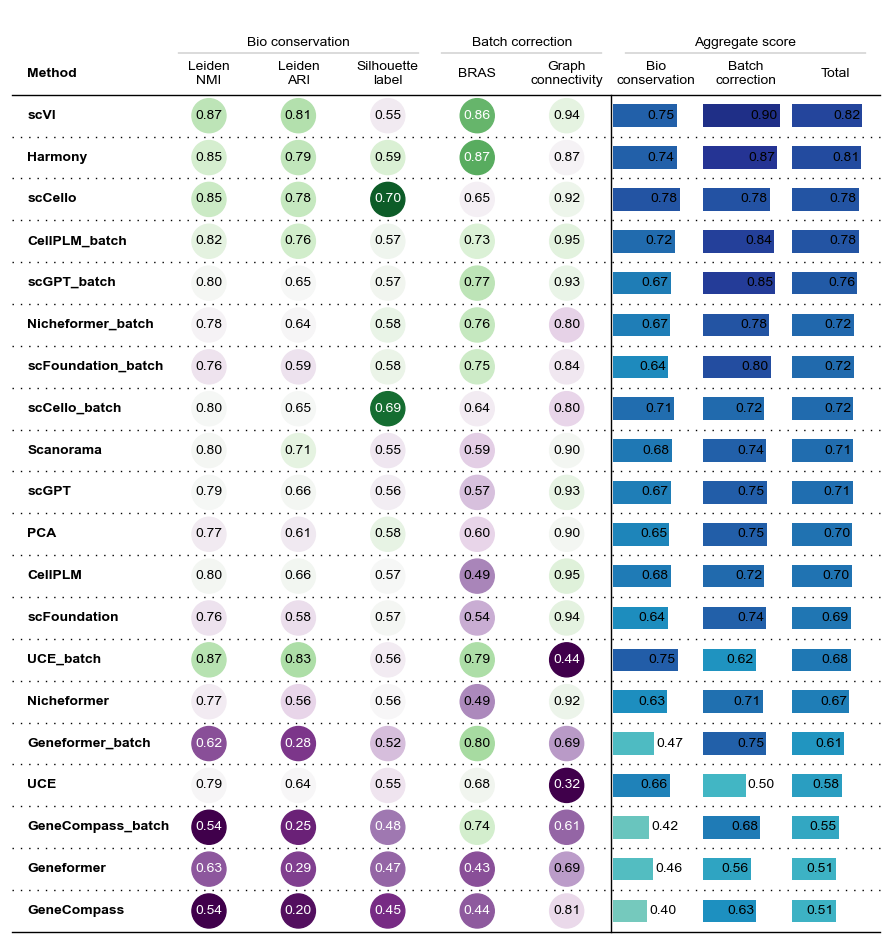

In [10]:
files = [
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_assay/cellplm"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/HLCA_assay/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/HLCA_assay/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scvi"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_assay/uce"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scfoundation"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scgpt"},
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_assay/geneformer"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_assay/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_assay/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_assay/genecompass"},
    

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/HLCA_assay_batch_normalize/genecompass"},

]

save_dir = "/home/wanglinting/scFM/Result/figure/HLCA_assay"

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df = EmbeddingMetrics.merge_embeddings(metrics_all)

# 可视化结果
plot_results_df(merged_df, show=True, save_dir=save_dir)


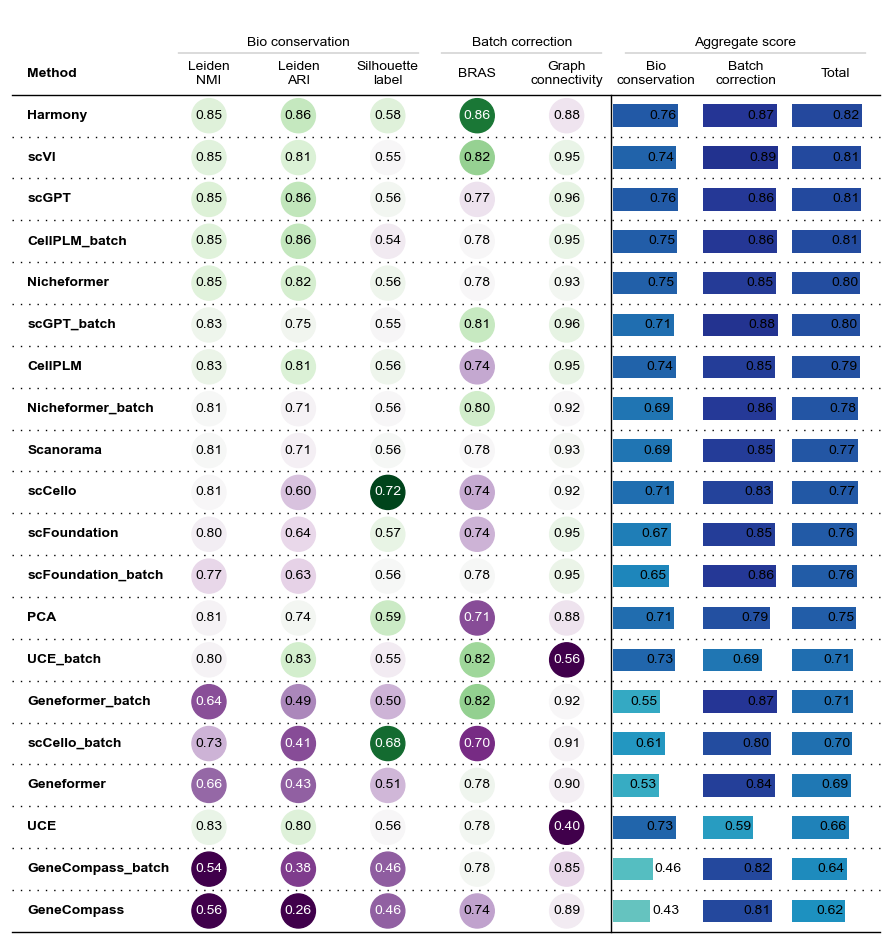

In [11]:
files = [
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_disease/cellplm"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/HLCA_disease/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/HLCA_disease/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scvi"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_disease/uce"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scfoundation"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scgpt"},
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_disease/geneformer"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_disease/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_disease/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_disease/genecompass"},
    
    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/HLCA_disease_batch_normalize/genecompass"},
]

save_dir = "/home/wanglinting/scFM/Result/figure/HLCA_disease"

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df = EmbeddingMetrics.merge_embeddings(metrics_all)

# 可视化结果
plot_results_df(merged_df, show=True, save_dir=save_dir)

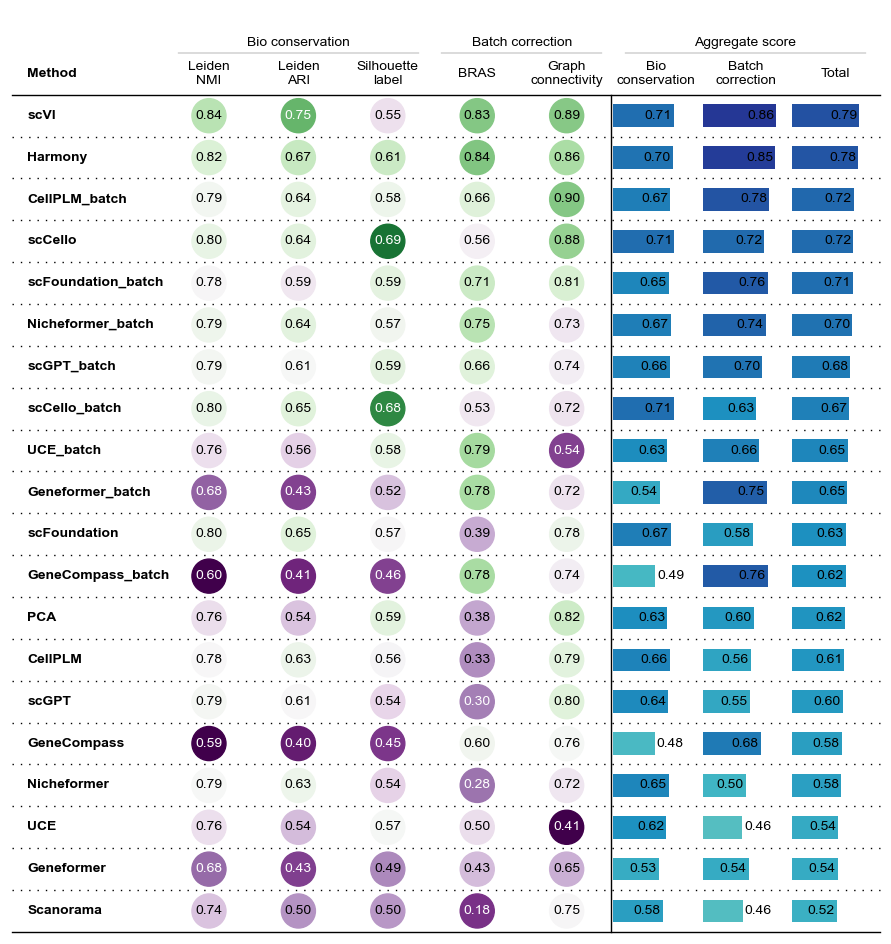

In [12]:
files = [
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_sn/cellplm"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/HLCA_sn/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/HLCA_sn/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scvi"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_sn/uce"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scfoundation"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scgpt"},
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_sn/geneformer"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_sn/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_sn/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_sn/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/HLCA_sn_batch_normalize/genecompass"},
]

save_dir = "/home/wanglinting/scFM/Result/figure/HLCA_sn"

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df = EmbeddingMetrics.merge_embeddings(metrics_all)

# 可视化结果
plot_results_df(merged_df, show=True, save_dir=save_dir)

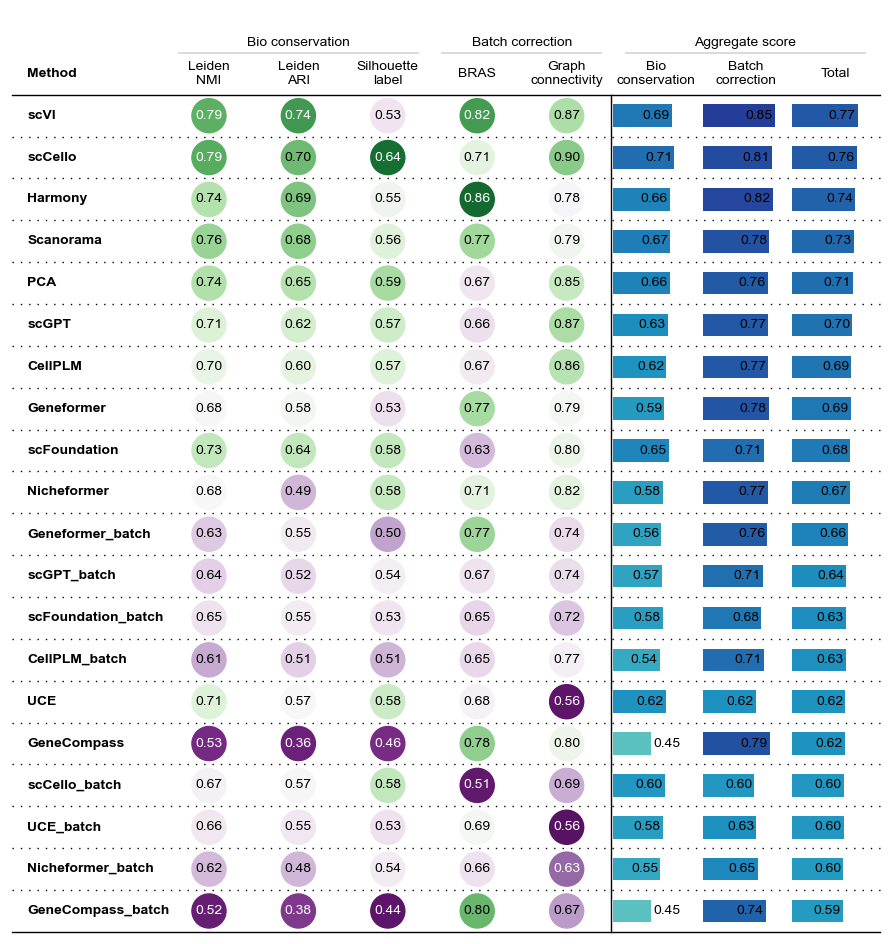

In [13]:
files = [
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/Immune/cellplm"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/Immune/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/Immune/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/Immune/scvi"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/Immune/uce"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/Immune/scfoundation"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/Immune/scgpt"},
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/Immune/geneformer"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/Immune/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/Immune/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/Immune/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/Immune/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/Immune_batch_normalize/genecompass"},
]

save_dir = "/home/wanglinting/scFM/Result/figure/Immune"

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df = EmbeddingMetrics.merge_embeddings(metrics_all)

# 可视化结果
plot_results_df(merged_df, show=True, save_dir=save_dir)

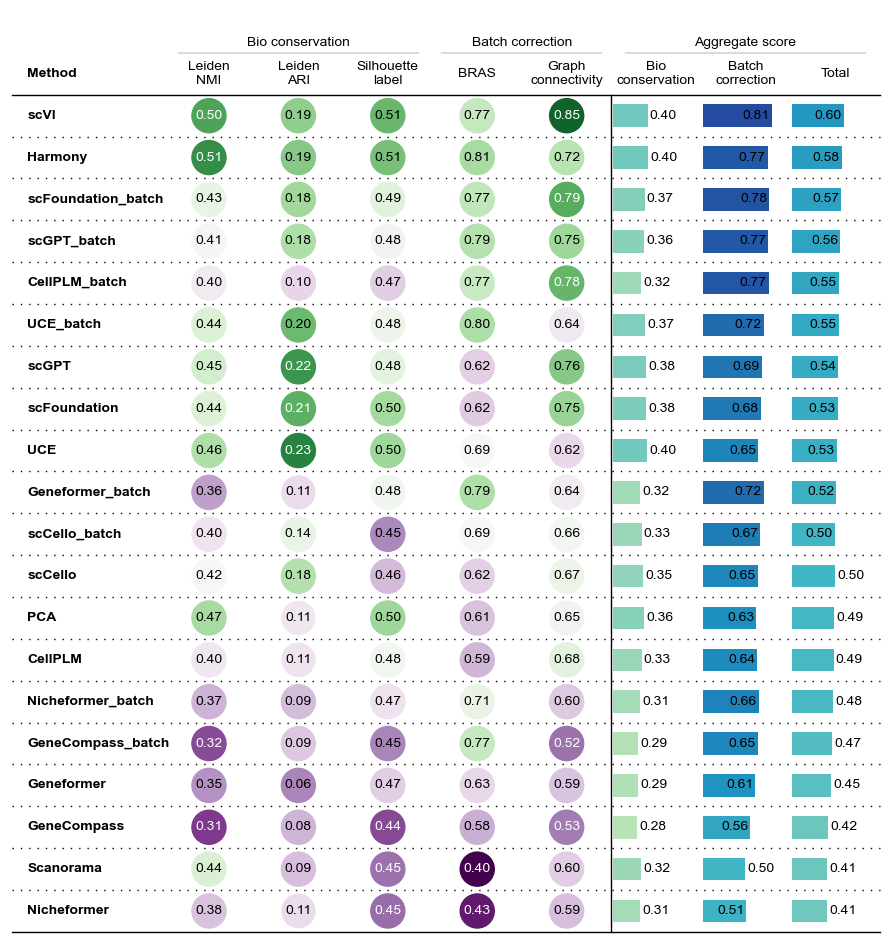

In [14]:
files = [
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/limb/cellplm"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/limb/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/limb/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/limb/scvi"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/limb/uce"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/limb/scfoundation"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/limb/scgpt"},
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/limb/geneformer"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/limb/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/limb/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/limb/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/limb/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/limb_batch_normalize/genecompass"},
]

save_dir = "/home/wanglinting/scFM/Result/figure/limb"

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df = EmbeddingMetrics.merge_embeddings(metrics_all)

# 可视化结果
plot_results_df(merged_df, show=True, save_dir=save_dir)

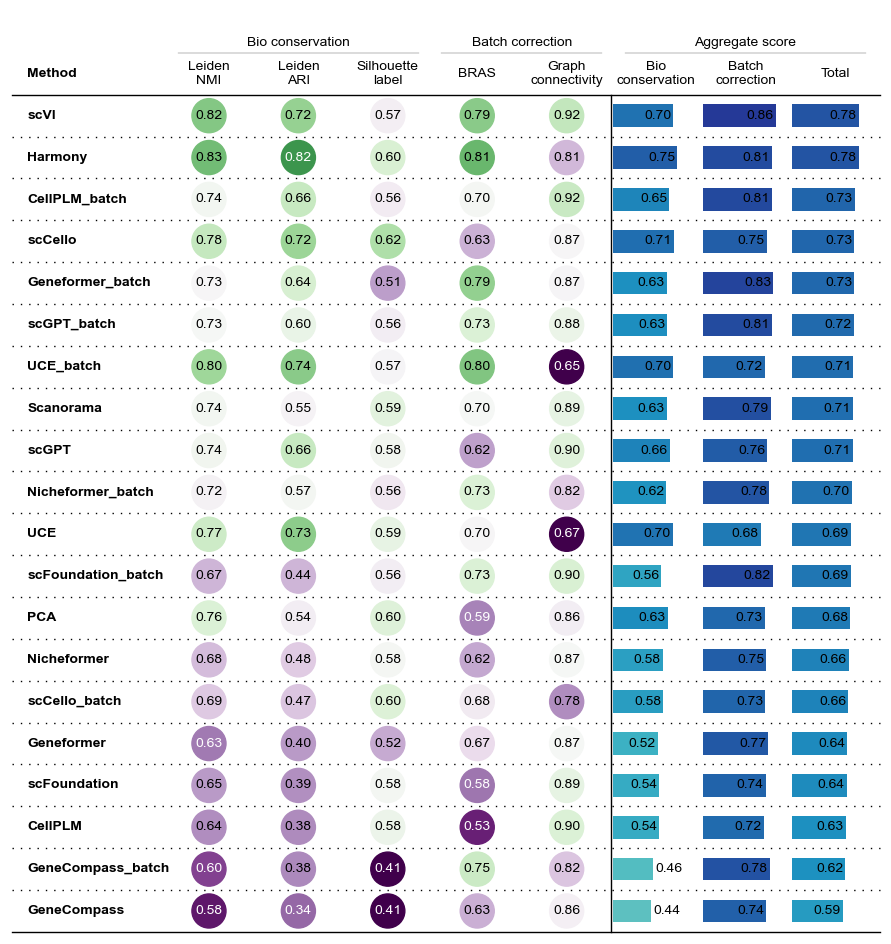

In [15]:
files = [
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/liver/cellplm"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/liver/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/liver/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/liver/scvi"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/liver/uce"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/liver/scfoundation"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/liver/scgpt"},
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/liver/geneformer"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/liver/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/liver/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/liver/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/liver/genecompass"},

    {"method": "Geneformer_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/geneformer"},
    {"method": "scGPT_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/scgpt"},
    {"method": "scFoundation_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/scfoundation"},
    {"method": "CellPLM_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/cellplm"},
    {"method": "UCE_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/uce"},
    {"method": "Nicheformer_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/nicheformer"},
    {"method": "scCello_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/sccello"},
    {"method": "GeneCompass_batch", "path": "/home/wanglinting/scFM/Result/liver_batch_normalize/genecompass"},
]


save_dir = "/home/wanglinting/scFM/Result/figure/liver"

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df = EmbeddingMetrics.merge_embeddings(metrics_all)

# 可视化结果
plot_results_df(merged_df, show=True, save_dir=save_dir)